In [2]:
!pip install -U torch==1.7.1 torchtext==0.4.0

# Reload environment
exit()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 5.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.7.1 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but

## Import require Libraries

In [1]:
import torch
import torchtext
from torchtext.data import Field, BucketIterator
import csv
import torch.nn as nn
from torchtext.datasets import TranslationDataset
from torchtext.data import TabularDataset
import random
import time
import matplotlib.pyplot as plt
import json
import numpy as np
import pandas as pd
import spacy
import re
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.utils import download_from_url, extract_archive
import io
from tqdm.auto import tqdm
from timeit import default_timer as timer

In [4]:

from typing import Tuple

import torch.nn.functional as F
from torch import Tensor

In [5]:
torchtext.__version__

'0.4.0'

In [6]:
import os
os.environ['PYTHONIOENCODING'] = 'utf-8'

## Device Agnostic code

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Get data

In [8]:
train_data = 'drive/MyDrive/Course/Sem2/DLOps/data/hi_train.tsv'
test_data = 'drive/MyDrive/Course/Sem2/DLOps/data/hi_test.tsv'
val_data = 'drive/MyDrive/Course/Sem2/DLOps/data/hi_dev.tsv'

In [9]:
# source_vocab = Field(tokenize=list, init_token='<sos>', eos_token='<eos>')
# target_vocab = Field(tokenize=list, init_token='<sos>', eos_token='<eos>')



source_field = Field(tokenize=list, init_token='<sos>', eos_token='<eos>')
target_field = Field(tokenize=list, init_token='<sos>', eos_token='<eos>')

In [10]:
# train_dataset = TabularDataset(path=train_data, format='tsv', fields=[('source', source_vocab), ('target', target_vocab)])
train_dataset = TabularDataset(path=train_data, format='tsv', fields=[('source', source_field), ('target', target_field)])

In [11]:
# train_dataset = train_dataset[0:10000]

### view dataset

In [ ]:
train_df = df = pd.read_csv(train_data, sep = '\t', names = ['Hindi', 'English', 'num'])
train_df.head()

,Hindi,English,num
0,अं,an,3
1,अंकगणित,ankganit,3
2,अंकल,uncle,4
3,अंकुर,ankur,4
4,अंकुरण,ankuran,3


In [ ]:
test_df = df = pd.read_csv(test_data, sep = '\t', names = ['Hindi', 'English', 'num'])
test_df.head()

,Hindi,English,num
0,अंक,ank,5
1,अंक,anka,1
2,अंकित,ankit,3
3,अंकों,anakon,1
4,अंकों,ankhon,1


In [ ]:
val_df = df = pd.read_csv(val_data, sep = '\t', names = ['Hindi', 'English', 'num'])
val_df.head()

,Hindi,English,num
0,अंकन,ankan,3
1,अंगकोर,angkor,3
2,अंगिरा,angira,3
3,अंगीठी,angithi,3
4,अंग्रेज,angrej,3


In [ ]:
len(train_df.index), len(test_df.index), len(val_df.index)

(44204, 4502, 4358)

In [ ]:
train_df = train_df.dropna()
val_df = val_df.dropna()
test_df = test_df.dropna()

In [ ]:
train, test, val = train_df.to_numpy(), test_df.to_numpy(), val_df.to_numpy()

In [ ]:
train_labels, train_texts = train[:,0], train[:,1]
test_labels, test_texts = test[:,0], test[:,1]
val_labels, val_texts = val[:,0], val[:,1]

In [ ]:
train_texts, train_labels

(array(['an', 'ankganit', 'uncle', ..., 'hyensang', 'xuanzang', 'om'],
       dtype=object),
 array(['अं', 'अंकगणित', 'अंकल', ..., 'ह्वेनसांग', 'ह्वेनसांग', 'ॐ'],
       dtype=object))

In [ ]:
train_texts.shape

(44202,)

### make tokens

In [12]:
# type(train_dataset)

In [11]:
train_dataset[0].source

['अ', 'ं']

In [12]:
# data_tuples = [{"source": train_dataset[i].source, "target": train_dataset[i].target} for i in range(len(train_dataset))]

# print(data_tuples)
# # with open("data.json", "w") as f:
# #     json.dump(data_tuples, f)

# with open("data_tsv.tsv", "w", newline='') as f:
#     writer = csv.DictWriter(f, fieldnames=data_tuples[0].keys(), delimiter='\t')
#     writer.writeheader()
#     writer.writerows(data_tuples)


In [13]:
# train_dataset = TabularDataset(
#     path="data_tsv.tsv",  # Set to None as we are providing data directly
#     format="tsv",
#     fields={"source": ('source', source_field), "target": ('target', target_field)},
#     skip_header=False
# )

In [14]:
# type(train_dataset)

In [15]:
# len(train_dataset)

In [16]:
# train_dataset[10].source, type(train_dataset[0].target)

In [17]:
# for i in range(len(train_dataset)):
#   while '[' in train_dataset[i].source:
#     train_dataset[i].source.remove('[')

#   while "'" in train_dataset[i].source:
#     train_dataset[i].source.remove("'")

#   while ',' in train_dataset[i].source:
#     train_dataset[i].source.remove(",")

#   while ' ' in train_dataset[i].source:
#     train_dataset[i].source.remove(" ")

#   while ']' in train_dataset[i].source:
#     train_dataset[i].source.remove("]")


#   while '[' in train_dataset[i].target:
#     train_dataset[i].target.remove('[')

#   while "'" in train_dataset[i].target:
#     train_dataset[i].target.remove("'")

#   while ',' in train_dataset[i].target:
#     train_dataset[i].target.remove(",")

#   while ' ' in train_dataset[i].target:
#     train_dataset[i].target.remove(" ")

#   while ']' in train_dataset[i].target:
#     train_dataset[i].target.remove("]")
 

In [18]:
# source_vocab.build_vocab(train_dataset.source)
# target_vocab.build_vocab(train_dataset.target)
source_field.build_vocab(train_dataset.source)
target_field.build_vocab(train_dataset.target)

In [19]:
target_field.tokenize('Jash Patel'), target_field.tokenize('अंकुरण')

(['J', 'a', 's', 'h', ' ', 'P', 'a', 't', 'e', 'l'],
 ['अ', 'ं', 'क', 'ु', 'र', 'ण'])

In [20]:
# hindi token
def hindi_alpha_tokenizer(text):
    # split the text into alphabetic tokens using regular expressions
    text = re.sub(r"[^ऀ-ॿ]+", " ", text)
    return [char for char in text]

# english token
def alpha_tokenizer(text):
    tokens = re.findall(r'\b[a-zA-Z]+\b', text)
    return tokens

In [21]:
def build_vocab(data, tokenizer):
  counter = Counter()
  for string_ in data:
    for s in string_:
      counter.update(tokenizer(s))
  return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


# source_vocab = build_vocab(train_texts, alpha_tokenizer)
# target_vocab = build_vocab(train_labels, hindi_alpha_tokenizer)

### Build dataset

In [22]:
def data_process(source, target):

  data = []
  for (s, t) in zip(source, target):
    source_tensor_ = torch.tensor([source_field[token] for token in source_field(s)],
                            dtype=torch.long)
    target_tensor_ = torch.tensor([target_field[token] for token in target_field(t)],
                            dtype=torch.long)
    data.append((source_tensor_, target_tensor_))
  return data

In [23]:
# train_dataset = data_process(train_labels, train_texts)
# val_dataset = data_process(val_labels, val_texts)
# test_dataset = data_process(test_labels, test_texts)

## Iterator

In [24]:
BATCH_SIZE = 128
train_iter = BucketIterator(train_dataset, batch_size = BATCH_SIZE, device = device)


In [25]:
test_dataset = TabularDataset(path=test_data, format='tsv', fields=[('source', source_field), ('target', target_field)])
test_iter = BucketIterator(test_dataset, batch_size = BATCH_SIZE, device = device)

val_dataset = TabularDataset(path=val_data, format='tsv', fields=[('source', source_field), ('target', target_field)])
val_iter = BucketIterator(val_dataset, batch_size = BATCH_SIZE, device = device)

## Tarin and test loop

In [26]:
# # train
# def train_loop(model, data_iter, loss_fn, optimizer, device):
#   model.train()

#   train_loss, train_acc = 0, 0

#   for data in data_iter:
#     x_train, y_train = data.source, data.target

#     print(len(x_train), len(y_train))

#     if device == 'cuda':
#       x_train, y_train = x_train.to(device), y_train.to(device)

#     output = model(x_train, y_train)

#     print(output.shape, y_train.shape)

#     output = output[1:].reshape(-1, output.shape[-1])
#     y_train = y_train[1:].reshape(-1)

#     optimizer.zero_grad()

#     print(len(output), len(y_train))
#     loss = loss_fn(output, y_train)

#     loss.backward()

#     optimizer.step()

#     train_loss += loss
  
#   train_loss /= len(data_iter)

#   return train_loss, train_acc

# def test_loop(model, data_iter, loss_fn, device):

#   test_loss, test_acc = 0, 0

#   model.eval()
#   with torch.inference_mode():
#     for data in data_iter:

#       x_test, y_test = data.source, data.target

#       if device == 'cuda':
#         x_test, y_test = x_test.to(device), y_test.to(device)

#       output = model(x_test, y_test)

#       output = output[1:].reshape(-1, output.shape[2])
#       y_test = y_test[1:].reshape(-1)


#       loss = loss_fn(output, y_test)

#       test_loss += loss

#     test_loss /= len(data_iter)

#   return test_loss, test_acc

In [27]:
INPUT_DIM = len(source_field.vocab)
print(INPUT_DIM)
OUTPUT_DIM = len(target_field.vocab)
print(OUTPUT_DIM)

67
30


In [28]:
def train(model, data_iter, loss_fn, optimizer, device):
    
    train_loss = 0

    model.train()
        
    for data in data_iter:
        src = data.source
        trg = data.target
        # print(src.shape)
        # print(trg.shape)
        optimizer.zero_grad()
        
        output = model(src, trg)
        # print(output.shape)
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = loss_fn(output, trg)
        loss.backward()
        
        optimizer.step()

        train_loss += loss

           
    train_loss /= len(data_iter)

    return train_loss

# test
def test_loop(model, data_iter, loss_fn, device):

  test_loss = 0

  model.eval()
  with torch.no_grad():
    for data in data_iter:

      x_test, y_test = data.source, data.target

      if device == 'cuda':
        x_test, y_test = x_test.to(device), y_test.to(device)

      output = model(x_test, y_test)
      # print(output.shape)
      
      output_dim = output.shape[-1]
      
      output = output[1:].view(-1, output_dim)
      y_test = y_test[1:].view(-1)
      
      loss = loss_fn(output, y_test)

      test_loss += loss

    test_loss /= len(data_iter)

  return test_loss

## Plot Function

In [29]:
def plot_graph(train_losses, test_losses):
  plt.figure(figsize = (10, 8))
  # plt.subplot(1, 2, 1)
  plt.plot(range(len(train_losses)), train_losses, label = "Train Loss")
  plt.plot(range(len(test_losses)), test_losses, label = "Test Loss")
  plt.legend()
  plt.xlabel("Epoches")
  plt.ylabel("Loss")
  plt.show()

## Loss Function

In [30]:
pad_index = target_field.vocab.stoi['<pad>']
loss_fn = nn.CrossEntropyLoss(ignore_index = pad_index)

# A

## Build Model of LSTM

### Encoder

In [ ]:
class LSTMEncoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
    

  def forward(self, x):
    embedding = self.dropout(self.embedding(x))
    ot, (h, c) = self.lstm(embedding)

    return h, c

### Decoder

In [ ]:
class LSTMDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
    super().__init__()
    self.hidden_size = hidden_size
    self.output_dim = output_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(output_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h, c):

    x = x.unsqueeze(0)

    embedding = self.dropout(self.embedding(x))

    ot, (h, c) = self.lstm(embedding, (h, c))

    predict = self.fc(ot.squeeze(0))

    # predict = predict.squeeze(0)

    return predict, h, c

### Seq2Seq 

In [ ]:
class LSTMSeq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source, target, teacher_force_ratio = 0.5):
    batch_size = target.shape[1]
    target_len = target.shape[0]

    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(target_len, batch_size, trg_vocab_size).to(device)

    h, c = self.encoder(source)

    x = target[0,:]

    for t in range(1, target_len):
      output, h, c = self.decoder(x, h, c)
      outputs[t] = output
      best_guess = output.argmax(1)

      x = target[t] if random.random() < teacher_force_ratio else best_guess

    return outputs

## Train LSTM Model

In [33]:
load_model = False
input_size_encoder = len(source_field.vocab)
input_size_decoder = len(target_field.vocab)
output_size = len(target_field.vocab)
encoder_embedding_size = 64
decoder_embedding_size = 64
hidden_size = 64
num_layers = 1
dropout_preb = 0.3


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.2647 | Test Loss: 1.7585

Epoch: 2 / 10
Train Loss: 1.5561 | Test Loss: 1.2685

Epoch: 3 / 10
Train Loss: 1.2943 | Test Loss: 1.1176

Epoch: 4 / 10
Train Loss: 1.1560 | Test Loss: 1.0115

Epoch: 5 / 10
Train Loss: 1.0767 | Test Loss: 0.9648

Epoch: 6 / 10
Train Loss: 1.0240 | Test Loss: 0.9214

Epoch: 7 / 10
Train Loss: 0.9740 | Test Loss: 0.9011

Epoch: 8 / 10
Train Loss: 0.9459 | Test Loss: 0.8707

Epoch: 9 / 10
Train Loss: 0.9216 | Test Loss: 0.8419

Epoch: 10 / 10
Train Loss: 0.9053 | Test Loss: 0.8350

Total Exe Time: 371.58694307299993 Sec


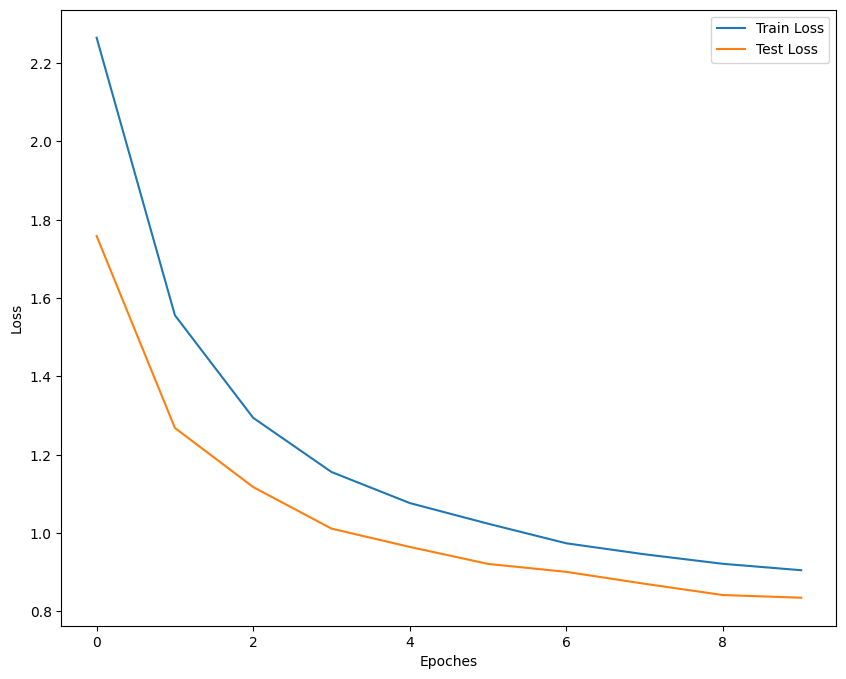

In [ ]:
epoches = 10


train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
lstm_encoder = LSTMEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
lstm_decoder = LSTMDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
lstm_model = LSTMSeq2Seq(lstm_encoder, lstm_decoder).to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-2)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(lstm_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(lstm_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)


## Build Model of RNN

### Encoder

In [ ]:
class RNNEncoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super().__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=p)
    

  def forward(self, x):
    embedding = self.dropout(self.embedding(x))
    ot, h = self.rnn(embedding)

    return h

### Decoder

In [ ]:
class RNNDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
    super().__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.output_dim = output_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)

    self.embedding = nn.Embedding(output_size, embedding_size)
    self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, dropout=p)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h):

    x = x.unsqueeze(0)

    embedding = self.dropout(self.embedding(x))

    ot, h = self.rnn(embedding, h)

    predict = self.fc(ot.squeeze(0))

    # predict = predict.squeeze(0)

    return predict, h

### Seq2Seq

In [ ]:
class RNNSeq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source, target, teacher_force_ratio = 0.5):
    batch_size = target.shape[1]
    target_len = target.shape[0]

    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(target_len, batch_size, trg_vocab_size).to(device)

    h = self.encoder(source)

    x = target[0,:]

    for t in range(1, target_len):
      output, h = self.decoder(x, h)
      outputs[t] = output
      best_guess = output.argmax(1)
      x = target[t] if torch.rand(1) < teacher_force_ratio else best_guess

    return outputs

## Train RNN Model

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.6220 | Test Loss: 2.5211

Epoch: 2 / 10
Train Loss: 2.4725 | Test Loss: 2.4045

Epoch: 3 / 10
Train Loss: 2.3974 | Test Loss: 2.3819

Epoch: 4 / 10
Train Loss: 2.3719 | Test Loss: 2.3769

Epoch: 5 / 10
Train Loss: 2.3669 | Test Loss: 2.3589

Epoch: 6 / 10
Train Loss: 2.3619 | Test Loss: 2.3627

Epoch: 7 / 10
Train Loss: 2.3580 | Test Loss: 2.3733

Epoch: 8 / 10
Train Loss: 2.3459 | Test Loss: 2.3305

Epoch: 9 / 10
Train Loss: 2.3446 | Test Loss: 2.3473

Epoch: 10 / 10
Train Loss: 2.3401 | Test Loss: 2.3399

Total Exe Time: 179.6433392459985 Sec


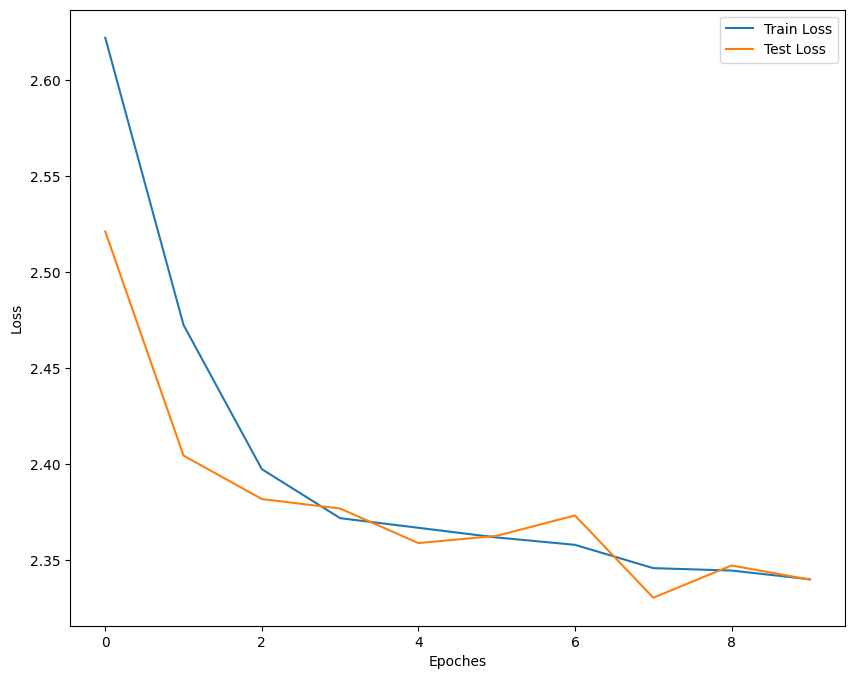

In [ ]:
epoches = 10


train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
rnn_encoder = RNNEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
rnn_decoder = RNNDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
rnn_model = RNNSeq2Seq(rnn_encoder, rnn_decoder).to(device)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 1e-3)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(rnn_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(rnn_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)


# B

## Hyperparameter training
### for 3 number of encoder and decoder system ram crashed so there for I avoid number 3 for encoder and decoder

In [ ]:
#Hypermeter
embedding_size = [16, 64]
# decoder_embedding_size = 64
hidden_size_ = [16, 64]

hyper_params = [(es, hs) for es in embedding_size for hs in hidden_size_]

## LSTM


iter: 1 / 4
Tuning with --- encoder embedding size: 16, encoder embedding size: 16, hidden size: 16


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.9608 | Test Loss: 2.7296

Epoch: 2 / 10
Train Loss: 2.6657 | Test Loss: 2.5683

Epoch: 3 / 10
Train Loss: 2.5622 | Test Loss: 2.5080

Epoch: 4 / 10
Train Loss: 2.5302 | Test Loss: 2.5018

Epoch: 5 / 10
Train Loss: 2.5047 | Test Loss: 2.4539

Epoch: 6 / 10
Train Loss: 2.4780 | Test Loss: 2.4279

Epoch: 7 / 10
Train Loss: 2.4393 | Test Loss: 2.3870

Epoch: 8 / 10
Train Loss: 2.3995 | Test Loss: 2.3779

Epoch: 9 / 10
Train Loss: 2.3985 | Test Loss: 2.3367

Epoch: 10 / 10
Train Loss: 2.3477 | Test Loss: 2.2990

Total Exe Time: 25.1321322770018 Sec


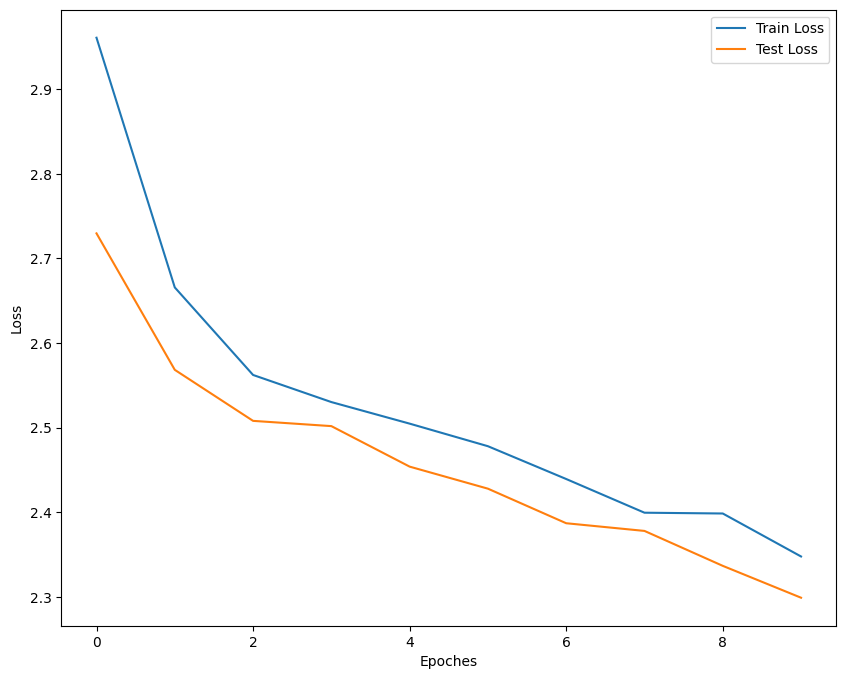


iter: 2 / 4
Tuning with --- encoder embedding size: 16, encoder embedding size: 16, hidden size: 64


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.7475 | Test Loss: 2.5713

Epoch: 2 / 10
Train Loss: 2.5738 | Test Loss: 2.5602

Epoch: 3 / 10
Train Loss: 2.5386 | Test Loss: 2.4800

Epoch: 4 / 10
Train Loss: 2.4808 | Test Loss: 2.4436

Epoch: 5 / 10
Train Loss: 2.4497 | Test Loss: 2.3830

Epoch: 6 / 10
Train Loss: 2.3887 | Test Loss: 2.3344

Epoch: 7 / 10
Train Loss: 2.3276 | Test Loss: 2.2345

Epoch: 8 / 10
Train Loss: 2.2247 | Test Loss: 2.1545

Epoch: 9 / 10
Train Loss: 2.1402 | Test Loss: 2.0754

Epoch: 10 / 10
Train Loss: 2.0301 | Test Loss: 1.9634

Total Exe Time: 36.38090182199812 Sec


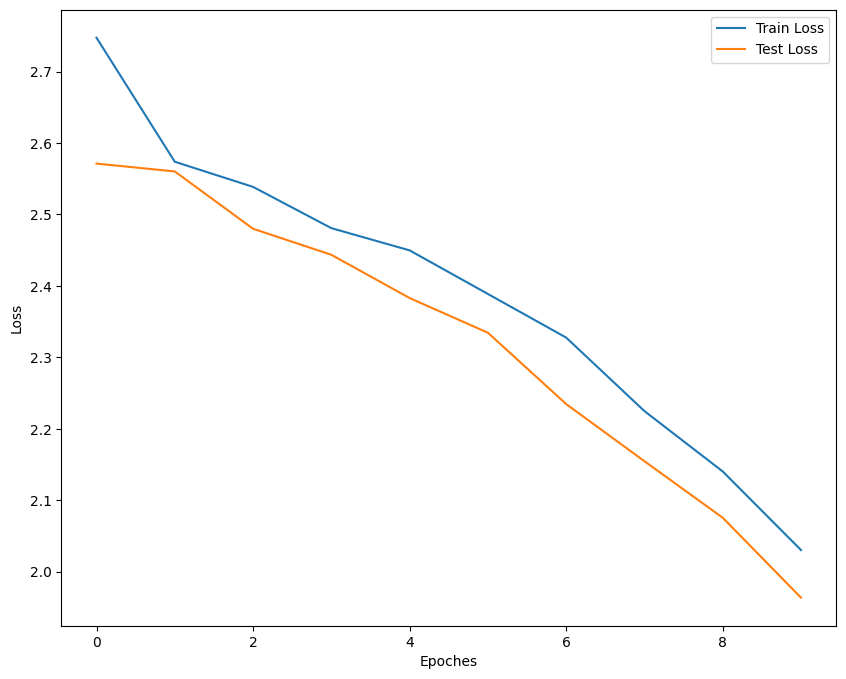


iter: 3 / 4
Tuning with --- encoder embedding size: 64, encoder embedding size: 64, hidden size: 16


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.9284 | Test Loss: 2.6291

Epoch: 2 / 10
Train Loss: 2.6017 | Test Loss: 2.5419

Epoch: 3 / 10
Train Loss: 2.5460 | Test Loss: 2.4779

Epoch: 4 / 10
Train Loss: 2.5031 | Test Loss: 2.4818

Epoch: 5 / 10
Train Loss: 2.4853 | Test Loss: 2.4331

Epoch: 6 / 10
Train Loss: 2.4527 | Test Loss: 2.4427

Epoch: 7 / 10
Train Loss: 2.4223 | Test Loss: 2.4073

Epoch: 8 / 10
Train Loss: 2.4251 | Test Loss: 2.4007

Epoch: 9 / 10
Train Loss: 2.3967 | Test Loss: 2.3710

Epoch: 10 / 10
Train Loss: 2.3899 | Test Loss: 2.3880

Total Exe Time: 23.460940119999577 Sec


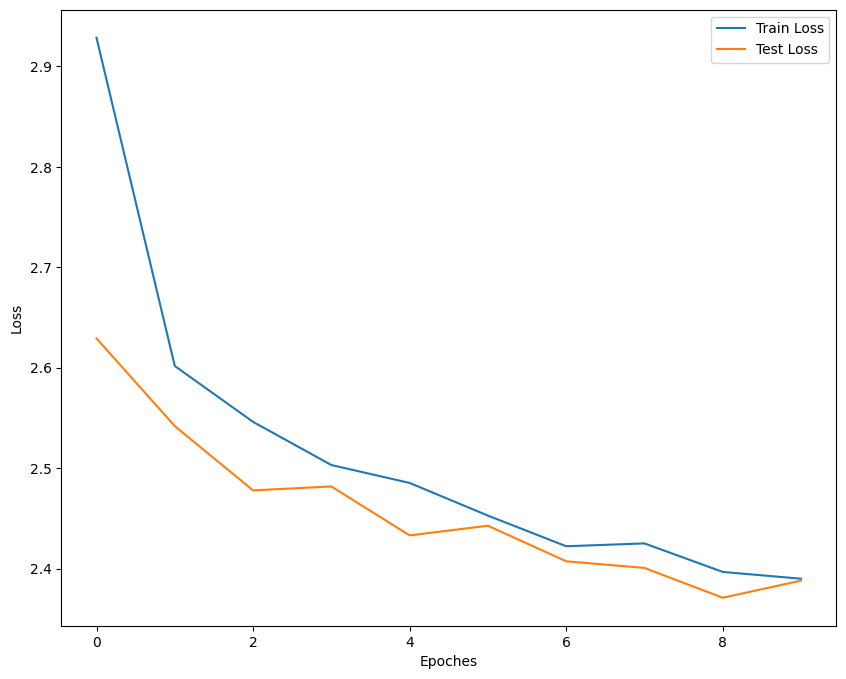


iter: 4 / 4
Tuning with --- encoder embedding size: 64, encoder embedding size: 64, hidden size: 64


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.7147 | Test Loss: 2.5272

Epoch: 2 / 10
Train Loss: 2.5076 | Test Loss: 2.4590

Epoch: 3 / 10
Train Loss: 2.4458 | Test Loss: 2.4954

Epoch: 4 / 10
Train Loss: 2.3976 | Test Loss: 2.3475

Epoch: 5 / 10
Train Loss: 2.3044 | Test Loss: 2.2748

Epoch: 6 / 10
Train Loss: 2.2678 | Test Loss: 2.1922

Epoch: 7 / 10
Train Loss: 2.1810 | Test Loss: 2.1112

Epoch: 8 / 10
Train Loss: 2.0772 | Test Loss: 1.9987

Epoch: 9 / 10
Train Loss: 1.9859 | Test Loss: 1.9187

Epoch: 10 / 10
Train Loss: 1.8427 | Test Loss: 1.8188

Total Exe Time: 36.316302588002145 Sec


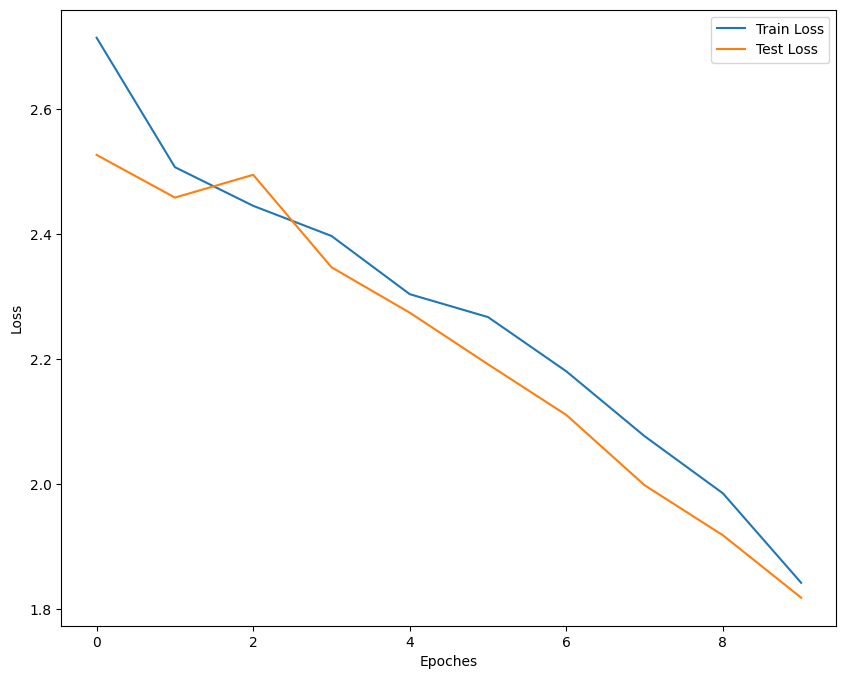

In [ ]:
epoches = 10

cur_iter,total_iter = 1, len(embedding_size)*len(hidden_size_)
for h_p in hyper_params:
  print()
  print(f"iter: {cur_iter} / {total_iter}")
  print(f"Tuning with --- encoder embedding size: {h_p[0]}, decoder embedding size: {h_p[0]}, hidden size: {h_p[1]}")
  train_loss_list, test_loss_list = [], []

  encoder_embedding_size = h_p[0]
  decoder_embedding_size = h_p[0]
  hidden_size = h_p[1]

  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  lstm_encoder = LSTMEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
  lstm_decoder = LSTMDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
  lstm_model = LSTMSeq2Seq(lstm_encoder, lstm_decoder).to(device)

  optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-2)

  start_time = timer()
  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  for epoch in tqdm(range(epoches)):
    print(f'Epoch: {epoch+1} / {epoches}')

    train_loss = train(lstm_model, val_iter, loss_fn, optimizer, device)
    test_loss = test_loop(lstm_model, test_iter, loss_fn, device)

    train_loss_list.append(train_loss.item())
    test_loss_list.append(test_loss.item())

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print()
    # print(f"Train Loss: {train_loss:.4f}")
  end_time = timer()

  print(f'Total Exe Time: {(end_time - start_time)} Sec')

  cur_iter += 1
  plot_graph(train_loss_list, test_loss_list)


## RNN


iter: 1 / 4
Tuning with --- encoder embedding size: 16, encoder embedding size: 16, hidden size: 16


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 0.5700 | Test Loss: 0.8037

Epoch: 2 / 10
Train Loss: 0.5205 | Test Loss: 0.8109

Epoch: 3 / 10
Train Loss: 0.5463 | Test Loss: 0.8294

Epoch: 4 / 10
Train Loss: 0.5403 | Test Loss: 0.7860

Epoch: 5 / 10
Train Loss: 0.5242 | Test Loss: 0.8269

Epoch: 6 / 10
Train Loss: 0.5278 | Test Loss: 0.8172

Epoch: 7 / 10
Train Loss: 0.5533 | Test Loss: 0.8030

Epoch: 8 / 10
Train Loss: 0.5392 | Test Loss: 0.8303

Epoch: 9 / 10
Train Loss: 0.5444 | Test Loss: 0.8201

Epoch: 10 / 10
Train Loss: 0.5206 | Test Loss: 0.8097

Total Exe Time: 43.46197586299968 Sec


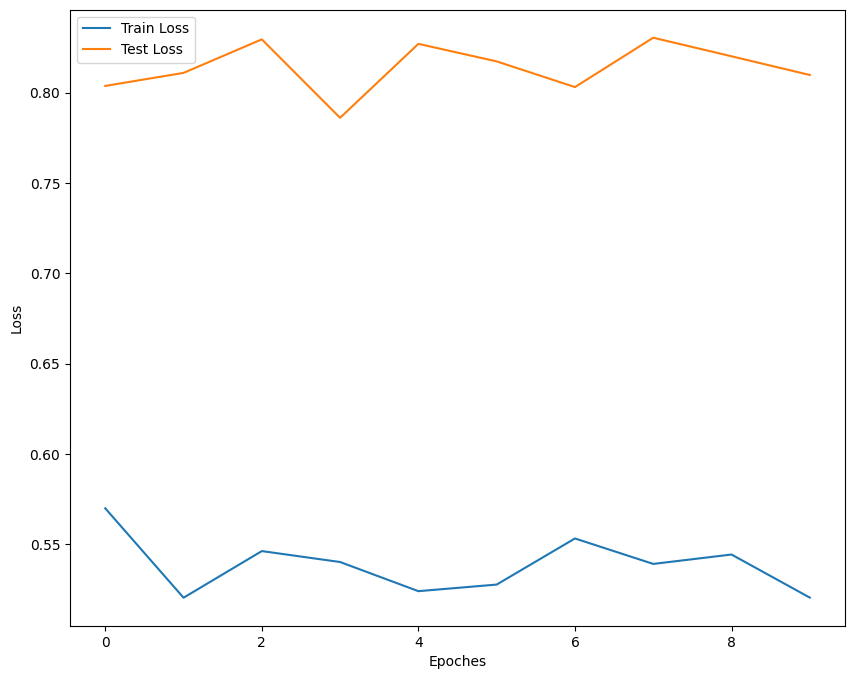


iter: 2 / 4
Tuning with --- encoder embedding size: 16, encoder embedding size: 16, hidden size: 64


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 0.5385 | Test Loss: 0.8068

Epoch: 2 / 10
Train Loss: 0.5148 | Test Loss: 0.8080

Epoch: 3 / 10
Train Loss: 0.5150 | Test Loss: 0.8068

Epoch: 4 / 10
Train Loss: 0.5004 | Test Loss: 0.8366

Epoch: 5 / 10
Train Loss: 0.5046 | Test Loss: 0.8383

Epoch: 6 / 10
Train Loss: 0.5318 | Test Loss: 0.8256

Epoch: 7 / 10
Train Loss: 0.5098 | Test Loss: 0.8031

Epoch: 8 / 10
Train Loss: 0.5179 | Test Loss: 0.8317

Epoch: 9 / 10
Train Loss: 0.5145 | Test Loss: 0.8132

Epoch: 10 / 10
Train Loss: 0.5258 | Test Loss: 0.8347

Total Exe Time: 42.04093869099961 Sec


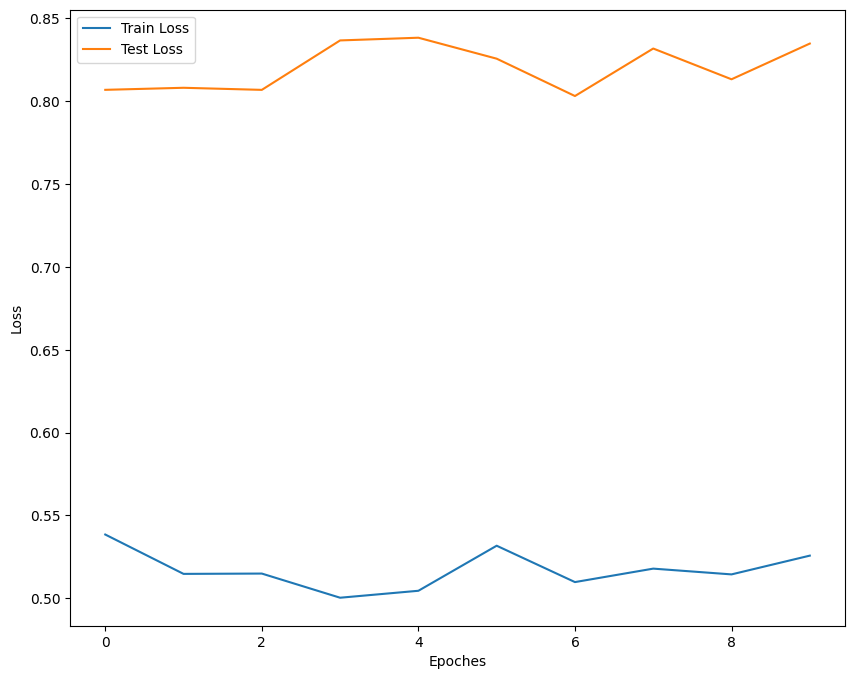


iter: 3 / 4
Tuning with --- encoder embedding size: 64, encoder embedding size: 64, hidden size: 16


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 0.5001 | Test Loss: 0.8024

Epoch: 2 / 10
Train Loss: 0.5057 | Test Loss: 0.8251

Epoch: 3 / 10
Train Loss: 0.5166 | Test Loss: 0.8286

Epoch: 4 / 10
Train Loss: 0.4950 | Test Loss: 0.8015

Epoch: 5 / 10
Train Loss: 0.5183 | Test Loss: 0.8348

Epoch: 6 / 10
Train Loss: 0.5035 | Test Loss: 0.8272

Epoch: 7 / 10
Train Loss: 0.5079 | Test Loss: 0.8036

Epoch: 8 / 10
Train Loss: 0.5015 | Test Loss: 0.8138

Epoch: 9 / 10
Train Loss: 0.5016 | Test Loss: 0.8156

Epoch: 10 / 10
Train Loss: 0.4833 | Test Loss: 0.8382

Total Exe Time: 41.84626204799861 Sec


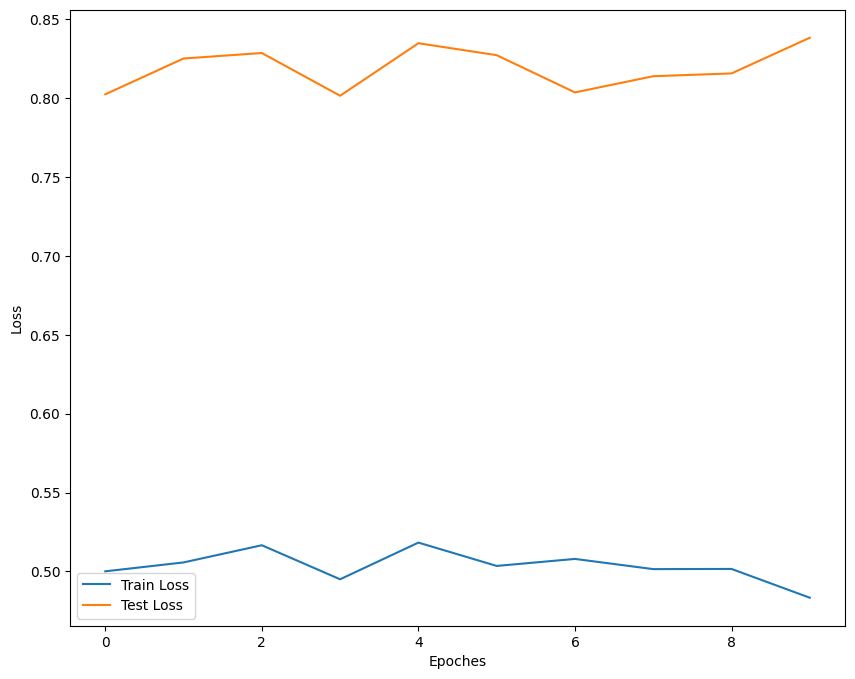


iter: 4 / 4
Tuning with --- encoder embedding size: 64, encoder embedding size: 64, hidden size: 64


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 0.5023 | Test Loss: 0.8269

Epoch: 2 / 10
Train Loss: 0.5076 | Test Loss: 0.8015

Epoch: 3 / 10
Train Loss: 0.4841 | Test Loss: 0.8225

Epoch: 4 / 10
Train Loss: 0.4915 | Test Loss: 0.8357

Epoch: 5 / 10
Train Loss: 0.5010 | Test Loss: 0.8235

Epoch: 6 / 10
Train Loss: 0.5014 | Test Loss: 0.8251

Epoch: 7 / 10
Train Loss: 0.5123 | Test Loss: 0.8450

Epoch: 8 / 10
Train Loss: 0.4815 | Test Loss: 0.8185

Epoch: 9 / 10
Train Loss: 0.4869 | Test Loss: 0.8345

Epoch: 10 / 10
Train Loss: 0.4931 | Test Loss: 0.8537

Total Exe Time: 42.91983340799925 Sec


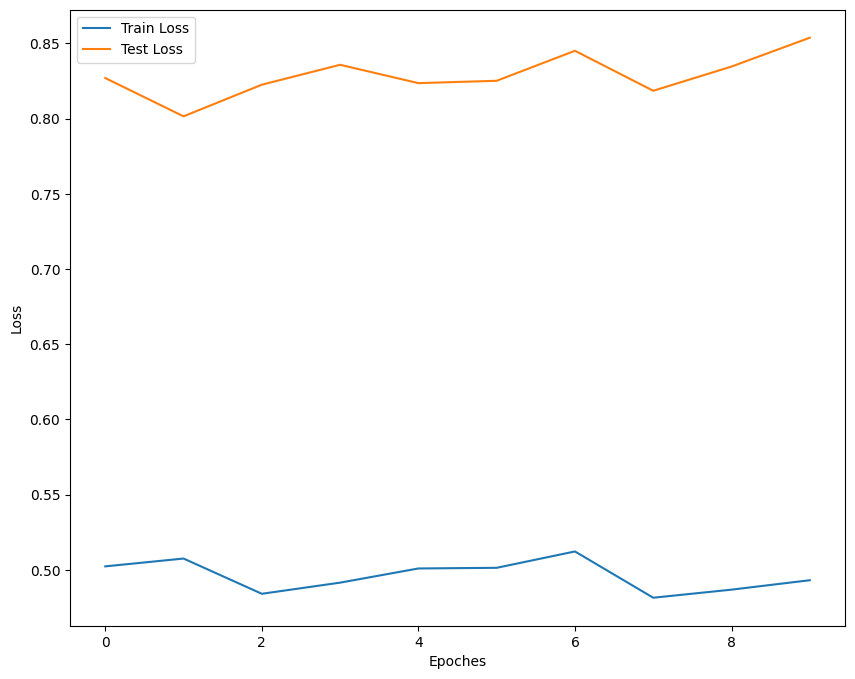

In [ ]:
epoches = 10

cur_iter,total_iter = 1, len(embedding_size)*len(hidden_size_)
for h_p in hyper_params:
  print()
  print(f"iter: {cur_iter} / {total_iter}")
  print(f"Tuning with --- encoder embedding size: {h_p[0]}, decoder embedding size: {h_p[0]}, hidden size: {h_p[1]}")
  train_loss_list, test_loss_list = [], []

  encoder_embedding_size = h_p[0]
  decoder_embedding_size = h_p[0]
  hidden_size = h_p[1]

  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  rnn_encoder = RNNEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
  rnn_decoder = RNNDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
  rnn_model = RNNSeq2Seq(rnn_encoder, rnn_decoder).to(device)

  optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-3)

  start_time = timer()
  torch.manual_seed(64)
  torch.cuda.manual_seed(64)
  for epoch in tqdm(range(epoches)):
    print(f'Epoch: {epoch+1} / {epoches}')

    train_loss = train(lstm_model, val_iter, loss_fn, optimizer, device)
    test_loss = test_loop(lstm_model, test_iter, loss_fn, device)

    train_loss_list.append(train_loss.item())
    test_loss_list.append(test_loss.item())

    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
    print()
    # print(f"Train Loss: {train_loss:.4f}")
  end_time = timer()

  print(f'Total Exe Time: {(end_time - start_time)} Sec')

  cur_iter += 1
  plot_graph(train_loss_list, test_loss_list)


# C

## Question 1: RNN take less time than LSTM
### LSTMs are a particular kind of RNN created to solve the vanishing gradient issue that might arise in conventional RNNs. To better capture long-range dependencies in sequential data, LSTMs employ a more intricate structure with gating features. In contrast to more straightforward RNNs, LSTMs may need more training data and longer training times due to their higher complexity.



## Question 2: Dropout give better output
### Yes it reduces the chance of overfitting

### Proof

In [ ]:
# for proof use rnn because lstm use to avoid overfitting in rnn

class RNNEncoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super().__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.rnn = nn.RNN(embedding_size, hidden_size, num_layers)
    

  def forward(self, x):
    embedding = self.embedding(x)
    ot, h = self.rnn(embedding)

    return h


class RNNDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
    super().__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.output_dim = output_size
    self.num_layers = num_layers
    # self.dropout = nn.Dropout(p)

    self.embedding = nn.Embedding(output_size, embedding_size)
    self.rnn = nn.RNN(embedding_size, hidden_size, num_layers)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, h):

    x = x.unsqueeze(0)

    embedding = self.embedding(x)

    ot, h = self.rnn(embedding, h)

    predict = self.fc(ot.squeeze(0))

    # predict = predict.squeeze(0)

    return predict, h


class RNNSeq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source, target, teacher_force_ratio = 0.5):
    batch_size = target.shape[1]
    target_len = target.shape[0]

    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(target_len, batch_size, trg_vocab_size).to(device)

    h = self.encoder(source)

    x = target[0,:]

    for t in range(1, target_len):
      output, h = self.decoder(x, h)
      outputs[t] = output
      best_guess = output.argmax(1)
      x = target[t] if torch.rand(1) < teacher_force_ratio else best_guess

    return outputs

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.6161 | Test Loss: 2.5447

Epoch: 2 / 10
Train Loss: 2.4663 | Test Loss: 2.3986

Epoch: 3 / 10
Train Loss: 2.3997 | Test Loss: 2.3713

Epoch: 4 / 10
Train Loss: 2.3710 | Test Loss: 2.3563

Epoch: 5 / 10
Train Loss: 2.3697 | Test Loss: 2.3545

Epoch: 6 / 10
Train Loss: 2.3644 | Test Loss: 2.3322

Epoch: 7 / 10
Train Loss: 2.3526 | Test Loss: 2.3638

Epoch: 8 / 10
Train Loss: 2.3476 | Test Loss: 2.3543

Epoch: 9 / 10
Train Loss: 2.3417 | Test Loss: 2.3149

Epoch: 10 / 10
Train Loss: 2.3392 | Test Loss: 2.3309

Total Exe Time: 191.12200533899886 Sec


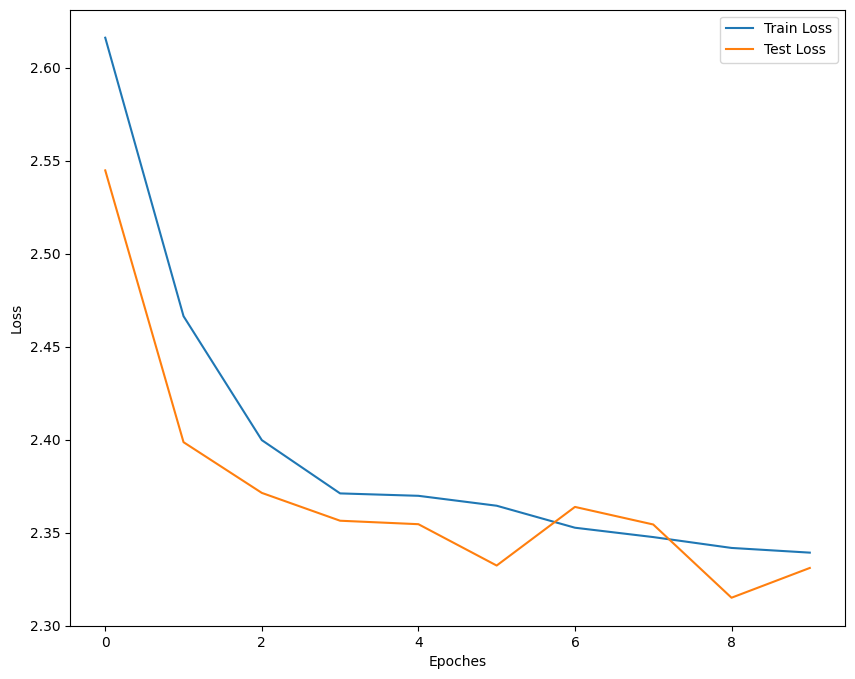

In [ ]:
# train model


load_model = False
input_size_encoder = len(source_field.vocab)
input_size_decoder = len(target_field.vocab)
output_size = len(target_field.vocab)
encoder_embedding_size = 64
decoder_embedding_size = 64
hidden_size = 64
num_layers = 1
dropout_preb = 0.3



epoches = 10


train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
rnn_encoder = RNNEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
rnn_decoder = RNNDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
rnn_model = RNNSeq2Seq(rnn_encoder, rnn_decoder).to(device)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 1e-3)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(rnn_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(rnn_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)


## Question 3: 
### RNN- and LSTM-based seq2seq models' performance can be significantly impacted by the size of the hidden layer. With larger hidden layer sizes, the model can capture more intricate patterns in the data, whereas with smaller hidden layer sizes, the model may be less capable of modelling and may be less able to catch fine-grained characteristics. When the size of the hidden layer is too small, the model could have trouble capturing the nuances of the input data, which could result in poorer accuracy or subpar performance. But bigger hidden layer sizes also call for greater computational power and might be more prone to overfitting, particularly if the dataset is tiny.

## proof LSTM

### Hidden size 8

Hidden size : 8


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.6222 | Test Loss: 2.5315

Epoch: 2 / 10
Train Loss: 2.4696 | Test Loss: 2.3988

Epoch: 3 / 10
Train Loss: 2.3892 | Test Loss: 2.3191

Epoch: 4 / 10
Train Loss: 2.3119 | Test Loss: 2.2285

Epoch: 5 / 10
Train Loss: 2.2546 | Test Loss: 2.1906

Epoch: 6 / 10
Train Loss: 2.2173 | Test Loss: 2.1548

Epoch: 7 / 10
Train Loss: 2.1939 | Test Loss: 2.1507

Epoch: 8 / 10
Train Loss: 2.1792 | Test Loss: 2.1247

Epoch: 9 / 10
Train Loss: 2.1575 | Test Loss: 2.1198

Epoch: 10 / 10
Train Loss: 2.1315 | Test Loss: 2.0821

Total Exe Time: 305.6570204640011 Sec


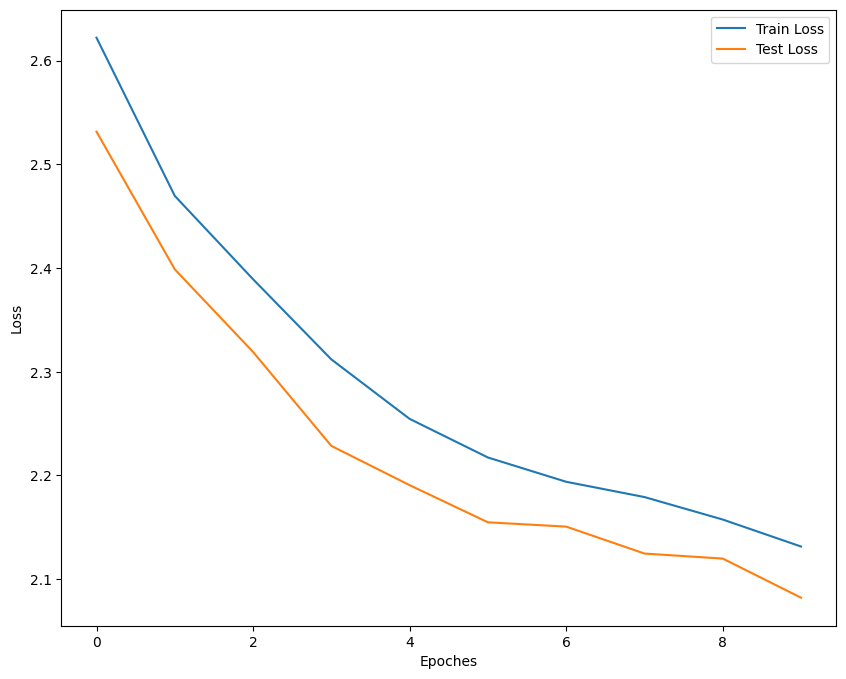

In [ ]:
print("Hidden size : 8")
epoches = 10
encoder_embedding_size = 64
decoder_embedding_size = 64
hidden_size = 8

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
lstm_encoder = LSTMEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
lstm_decoder = LSTMDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
lstm_model = LSTMSeq2Seq(lstm_encoder, lstm_decoder).to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-2)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(lstm_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(lstm_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)

### Hidden size 16

Hidden size : 16


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.5508 | Test Loss: 2.4244

Epoch: 2 / 10
Train Loss: 2.3331 | Test Loss: 2.1067

Epoch: 3 / 10
Train Loss: 2.0746 | Test Loss: 1.9467

Epoch: 4 / 10
Train Loss: 1.9520 | Test Loss: 1.8668

Epoch: 5 / 10
Train Loss: 1.8906 | Test Loss: 1.8227

Epoch: 6 / 10
Train Loss: 1.8393 | Test Loss: 1.7365

Epoch: 7 / 10
Train Loss: 1.7875 | Test Loss: 1.7033

Epoch: 8 / 10
Train Loss: 1.7291 | Test Loss: 1.6110

Epoch: 9 / 10
Train Loss: 1.6692 | Test Loss: 1.5649

Epoch: 10 / 10
Train Loss: 1.6177 | Test Loss: 1.5025

Total Exe Time: 214.62258912900143 Sec


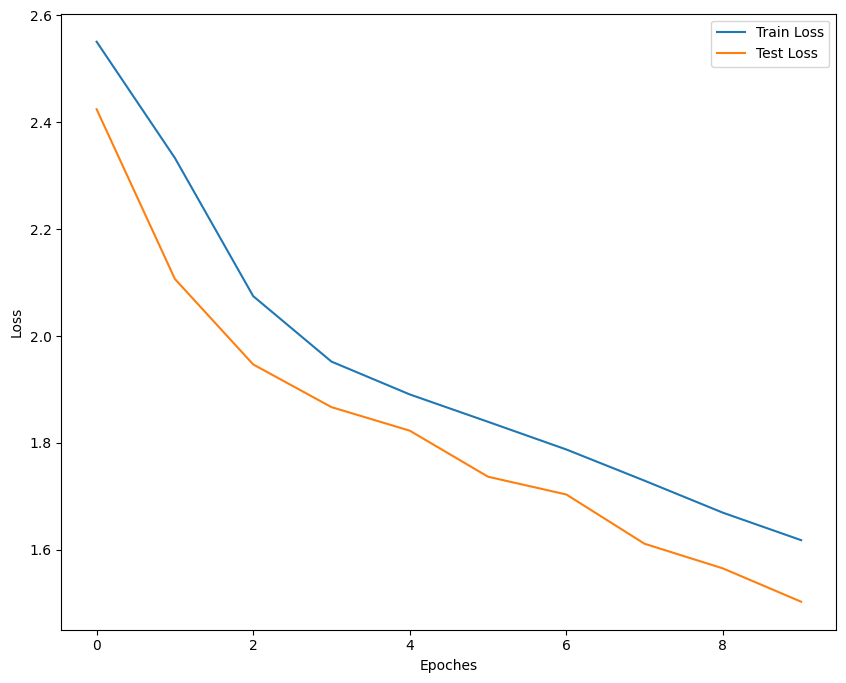

In [ ]:
print("Hidden size : 16")
epoches = 10
hidden_size = 16

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
lstm_encoder = LSTMEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
lstm_decoder = LSTMDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
lstm_model = LSTMSeq2Seq(lstm_encoder, lstm_decoder).to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-2)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(lstm_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(lstm_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)

### Hidden size 32

Hidden size : 32


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.4620 | Test Loss: 2.2944

Epoch: 2 / 10
Train Loss: 2.0349 | Test Loss: 1.8268

Epoch: 3 / 10
Train Loss: 1.7357 | Test Loss: 1.5490

Epoch: 4 / 10
Train Loss: 1.5522 | Test Loss: 1.3915

Epoch: 5 / 10
Train Loss: 1.4602 | Test Loss: 1.3206

Epoch: 6 / 10
Train Loss: 1.3814 | Test Loss: 1.2422

Epoch: 7 / 10
Train Loss: 1.3262 | Test Loss: 1.1967

Epoch: 8 / 10
Train Loss: 1.2880 | Test Loss: 1.1803

Epoch: 9 / 10
Train Loss: 1.2641 | Test Loss: 1.1513

Epoch: 10 / 10
Train Loss: 1.2403 | Test Loss: 1.1293

Total Exe Time: 258.05460119000054 Sec


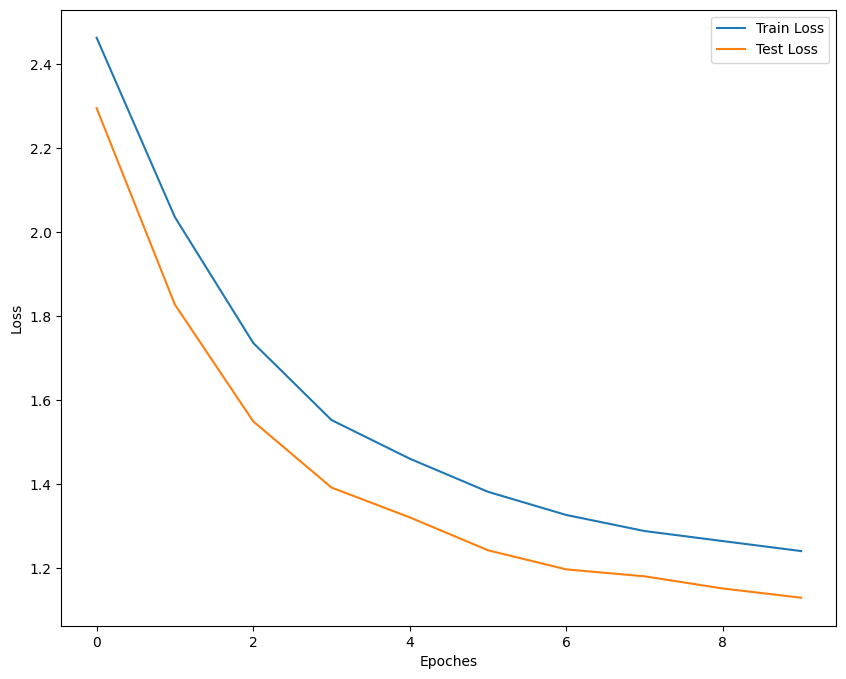

In [ ]:
print("Hidden size : 32")
epoches = 10
hidden_size = 32

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
lstm_encoder = LSTMEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
lstm_decoder = LSTMDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
lstm_model = LSTMSeq2Seq(lstm_encoder, lstm_decoder).to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-2)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(lstm_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(lstm_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)

### Hidden size 64

Hidden size : 64


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.3251 | Test Loss: 1.8303

Epoch: 2 / 10
Train Loss: 1.5687 | Test Loss: 1.2383

Epoch: 3 / 10
Train Loss: 1.2092 | Test Loss: 1.0562

Epoch: 4 / 10
Train Loss: 1.0835 | Test Loss: 0.9757

Epoch: 5 / 10
Train Loss: 1.0075 | Test Loss: 0.8843

Epoch: 6 / 10
Train Loss: 0.9698 | Test Loss: 0.8788

Epoch: 7 / 10
Train Loss: 0.9452 | Test Loss: 0.8515

Epoch: 8 / 10
Train Loss: 0.9186 | Test Loss: 0.8222

Epoch: 9 / 10
Train Loss: 0.9036 | Test Loss: 0.8232

Epoch: 10 / 10
Train Loss: 0.8777 | Test Loss: 0.7732

Total Exe Time: 357.4732475150013 Sec


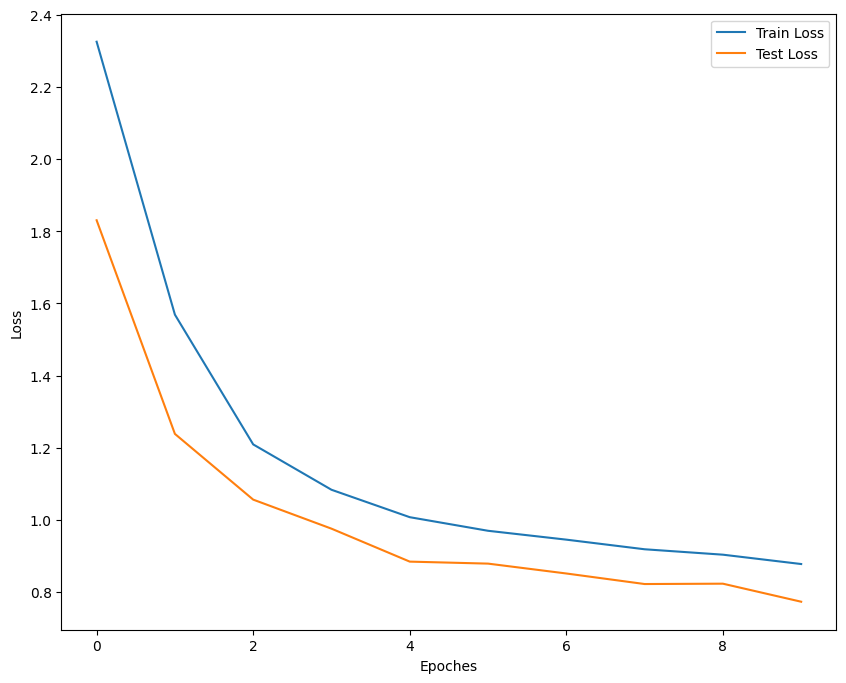

In [ ]:
print("Hidden size : 64")
epoches = 10
hidden_size = 64

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
lstm_encoder = LSTMEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
lstm_decoder = LSTMDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
lstm_model = LSTMSeq2Seq(lstm_encoder, lstm_decoder).to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr = 1e-2)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(lstm_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(lstm_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)

## Proof RNN

### Hidden size 8 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.8980 | Test Loss: 2.7080

Epoch: 2 / 10
Train Loss: 2.6882 | Test Loss: 2.6406

Epoch: 3 / 10
Train Loss: 2.6220 | Test Loss: 2.5758

Epoch: 4 / 10
Train Loss: 2.5779 | Test Loss: 2.5504

Epoch: 5 / 10
Train Loss: 2.5742 | Test Loss: 2.5521

Epoch: 6 / 10
Train Loss: 2.5652 | Test Loss: 2.5398

Epoch: 7 / 10
Train Loss: 2.5589 | Test Loss: 2.5334

Epoch: 8 / 10
Train Loss: 2.5528 | Test Loss: 2.5521

Epoch: 9 / 10
Train Loss: 2.5492 | Test Loss: 2.5215

Epoch: 10 / 10
Train Loss: 2.5525 | Test Loss: 2.5224

Total Exe Time: 160.84545144000003 Sec


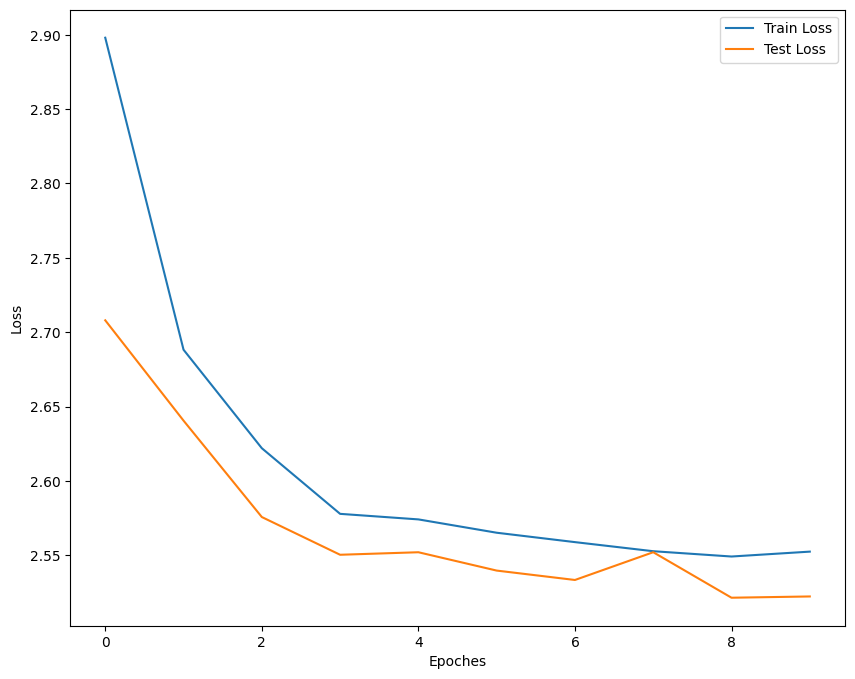

In [ ]:
epoches = 10
hidden_size = 8

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
rnn_encoder = RNNEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
rnn_decoder = RNNDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
rnn_model = RNNSeq2Seq(rnn_encoder, rnn_decoder).to(device)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 1e-3)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(rnn_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(rnn_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)


### Hidden size 16

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.8248 | Test Loss: 2.6153

Epoch: 2 / 10
Train Loss: 2.5911 | Test Loss: 2.5357

Epoch: 3 / 10
Train Loss: 2.5476 | Test Loss: 2.5145

Epoch: 4 / 10
Train Loss: 2.5195 | Test Loss: 2.5245

Epoch: 5 / 10
Train Loss: 2.4903 | Test Loss: 2.4924

Epoch: 6 / 10
Train Loss: 2.4600 | Test Loss: 2.4145

Epoch: 7 / 10
Train Loss: 2.4428 | Test Loss: 2.4111

Epoch: 8 / 10
Train Loss: 2.4255 | Test Loss: 2.4155

Epoch: 9 / 10
Train Loss: 2.4123 | Test Loss: 2.4010

Epoch: 10 / 10
Train Loss: 2.4088 | Test Loss: 2.3929

Total Exe Time: 156.07999123099944 Sec


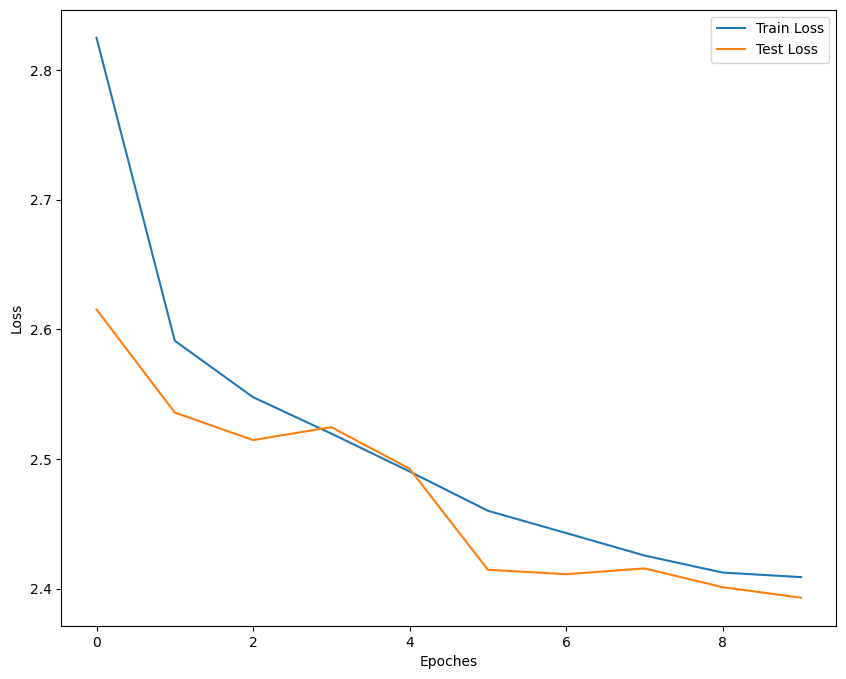

In [ ]:
epoches = 10
hidden_size = 16

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
rnn_encoder = RNNEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
rnn_decoder = RNNDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
rnn_model = RNNSeq2Seq(rnn_encoder, rnn_decoder).to(device)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 1e-3)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(rnn_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(rnn_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)


### Hidden size 32

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.7020 | Test Loss: 2.5361

Epoch: 2 / 10
Train Loss: 2.5341 | Test Loss: 2.5118

Epoch: 3 / 10
Train Loss: 2.4789 | Test Loss: 2.4131

Epoch: 4 / 10
Train Loss: 2.4174 | Test Loss: 2.4045

Epoch: 5 / 10
Train Loss: 2.4010 | Test Loss: 2.3877

Epoch: 6 / 10
Train Loss: 2.3880 | Test Loss: 2.3618

Epoch: 7 / 10
Train Loss: 2.3812 | Test Loss: 2.3720

Epoch: 8 / 10
Train Loss: 2.3731 | Test Loss: 2.3615

Epoch: 9 / 10
Train Loss: 2.3697 | Test Loss: 2.3545

Epoch: 10 / 10
Train Loss: 2.3700 | Test Loss: 2.3443

Total Exe Time: 163.64969378000023 Sec


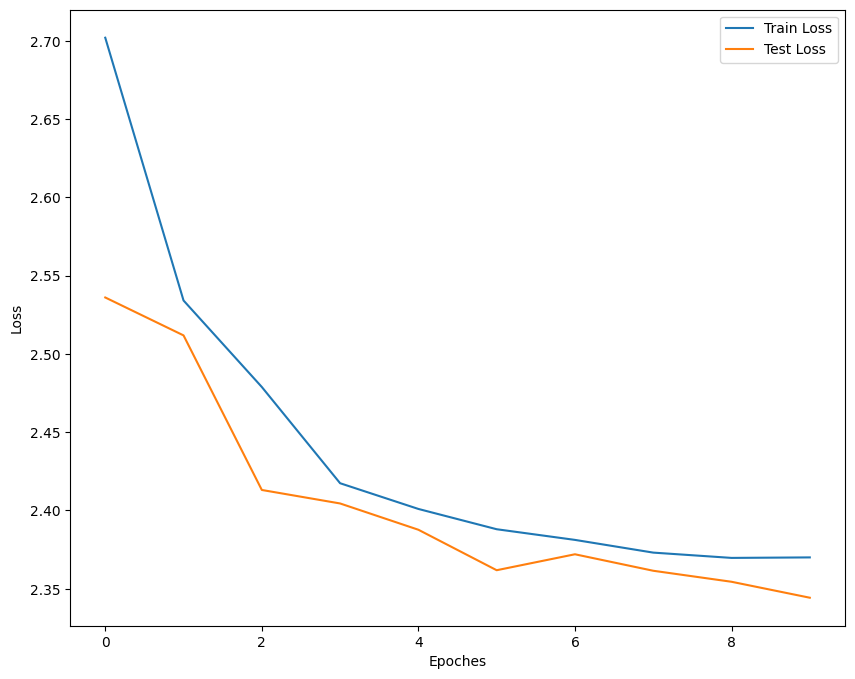

In [ ]:
epoches = 10
hidden_size = 32

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
rnn_encoder = RNNEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
rnn_decoder = RNNDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
rnn_model = RNNSeq2Seq(rnn_encoder, rnn_decoder).to(device)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 1e-3)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(rnn_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(rnn_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)


### Hidden size 64

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 2.6173 | Test Loss: 2.5373

Epoch: 2 / 10
Train Loss: 2.4689 | Test Loss: 2.4035

Epoch: 3 / 10
Train Loss: 2.4025 | Test Loss: 2.3853

Epoch: 4 / 10
Train Loss: 2.3706 | Test Loss: 2.3707

Epoch: 5 / 10
Train Loss: 2.3645 | Test Loss: 2.3725

Epoch: 6 / 10
Train Loss: 2.3591 | Test Loss: 2.3370

Epoch: 7 / 10
Train Loss: 2.3477 | Test Loss: 2.3418

Epoch: 8 / 10
Train Loss: 2.3442 | Test Loss: 2.3391

Epoch: 9 / 10
Train Loss: 2.3373 | Test Loss: 2.3216

Epoch: 10 / 10
Train Loss: 2.3354 | Test Loss: 2.3322

Total Exe Time: 175.14109500199993 Sec


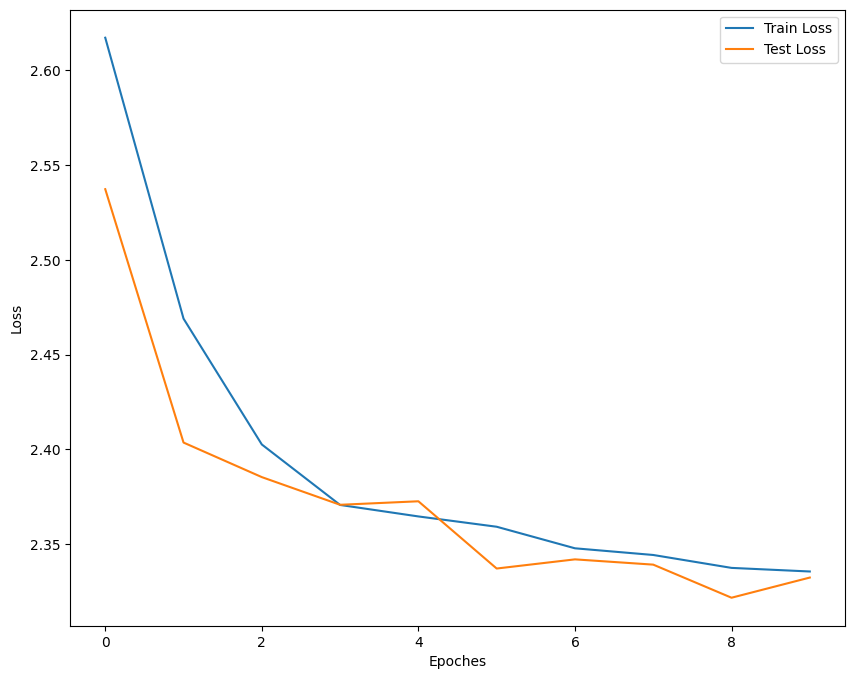

In [ ]:
epoches = 10
hidden_size = 64

train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
rnn_encoder = RNNEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
rnn_decoder = RNNDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
rnn_model = RNNSeq2Seq(rnn_encoder, rnn_decoder).to(device)

optimizer = torch.optim.Adam(rnn_model.parameters(), lr = 1e-3)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(rnn_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(rnn_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)


# D

## LSTM with Attention 

In [37]:
# encoder
class ATEncoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(input_size, embedding_size)
    self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, bidirectional=True)

    self.fc_h = nn.Linear(hidden_size*2, hidden_size)
    self.fc_c = nn.Linear(hidden_size*2, hidden_size)
    

  def forward(self, x):
    embedding = self.dropout(self.embedding(x))
    es, (h, c) = self.lstm(embedding)

    h = self.fc_h(torch.cat((h[0:1], h[1:2]), dim=2))
    c = self.fc_c(torch.cat((c[0:1], c[1:2]), dim=2))

    return es, h, c


# decoder
class ATDecoder(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, output_size, num_layers, p):
    super().__init__()
    self.hidden_size = hidden_size
    self.output_dim = output_size
    self.num_layers = num_layers
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(output_size, embedding_size)
    self.lstm = nn.LSTM(hidden_size*2 + embedding_size, hidden_size, num_layers)

    self.energy = nn.Linear(hidden_size*3, 1)
    self.softmax = nn.Softmax(dim=0)
    self.relu = nn.ReLU()


    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, es, h, c):

    x = x.unsqueeze(0)

    embedding = self.dropout(self.embedding(x))

    sequence_length = es.shape[0]
    h_reshaped = h.repeat(sequence_length, 1, 1)

    energy = self.relu(self.energy(torch.cat((h_reshaped, es), dim = 2)))

    attention = self.softmax(energy)

    attention = attention.permute(1, 2, 0)

    es = es.permute(1,0,2)

    context_vector = torch.bmm(attention, es).permute(1, 0, 2)

    lstm_input = torch.cat((context_vector, embedding), dim=2)

    ot, (h, c) = self.lstm(lstm_input, (h, c))

    predict = self.fc(ot.squeeze(0))

    # predict = predict.squeeze(0)

    return predict, h, c


# Seq2Seq
class ATSeq2Seq(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, source, target, teacher_force_ratio = 0.5):
    batch_size = target.shape[1]
    target_len = target.shape[0]

    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(target_len, batch_size, trg_vocab_size).to(device)

    es, h, c = self.encoder(source)

    x = target[0,:]

    for t in range(1, target_len):
      output, h, c = self.decoder(x, es, h, c)
      outputs[t] = output
      best_guess = output.argmax(1)

      x = target[t] if random.random() < teacher_force_ratio else best_guess

    return outputs

## Train Attention Model

In [ ]:
load_model = False
input_size_encoder = len(source_field.vocab)
input_size_decoder = len(target_field.vocab)
output_size = len(target_field.vocab)
encoder_embedding_size = 16
decoder_embedding_size = 16
hidden_size = 32
num_layers = 1
dropout_preb = 0.3

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 / 10
Train Loss: 1.6954 | Test Loss: 1.0312

Epoch: 2 / 10
Train Loss: 1.0174 | Test Loss: 0.8354

Epoch: 3 / 10
Train Loss: 0.8877 | Test Loss: 0.7896

Epoch: 4 / 10
Train Loss: 0.8209 | Test Loss: 0.7149

Epoch: 5 / 10
Train Loss: 0.7881 | Test Loss: 0.6874

Epoch: 6 / 10
Train Loss: 0.7553 | Test Loss: 0.6999

Epoch: 7 / 10
Train Loss: 0.7506 | Test Loss: 0.7079

Epoch: 8 / 10
Train Loss: 0.7346 | Test Loss: 0.6843

Epoch: 9 / 10
Train Loss: 0.7228 | Test Loss: 0.6763

Epoch: 10 / 10
Train Loss: 0.7072 | Test Loss: 0.6704

Total Exe Time: 654.0894354630001 Sec


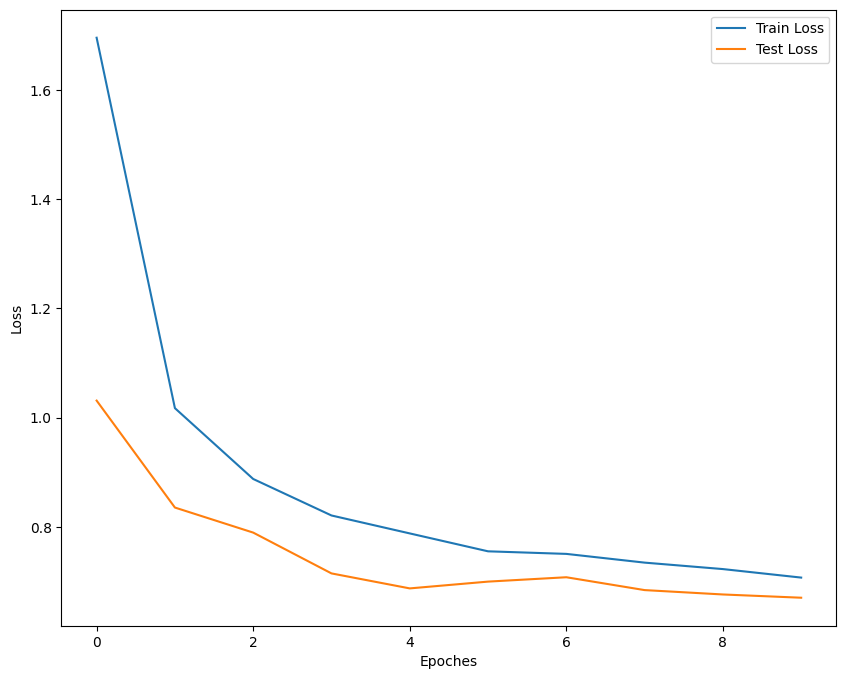

In [38]:
epoches = 10


train_loss_list, test_loss_list = [], []

torch.manual_seed(64)
torch.cuda.manual_seed(64)
at_encoder = ATEncoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, dropout_preb).to(device)
at_decoder = ATDecoder(input_size_decoder, decoder_embedding_size, hidden_size, output_size, num_layers, dropout_preb).to(device)
at_model = ATSeq2Seq(at_encoder, at_decoder).to(device)

optimizer = torch.optim.Adam(at_model.parameters(), lr = 1e-2)

start_time = timer()
torch.manual_seed(64)
torch.cuda.manual_seed(64)
for epoch in tqdm(range(epoches)):
  print(f'Epoch: {epoch+1} / {epoches}')

  train_loss = train(at_model, train_iter, loss_fn, optimizer, device)
  test_loss = test_loop(at_model, test_iter, loss_fn, device)

  train_loss_list.append(train_loss.item())
  test_loss_list.append(test_loss.item())

  print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")
  print()
  # print(f"Train Loss: {train_loss:.4f}")
end_time = timer()

print(f'Total Exe Time: {(end_time - start_time)} Sec')

plot_graph(train_loss_list, test_loss_list)
